In [2]:
from ipynb.fs.full.interact_with_app import *

In [115]:
import numpy as np
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

class ImageTool(object):
    def __init__(self, filename=None, image=None, size=None):
        self.filename = filename
        self.image = image

        #if image is None:
        #    self.image = ImageTool.load(filename)
        
        if size is not None:
            self.image = Image.new('RGB', size)
        
        #ratio = h / self.image.size[1]
        #newsize = (int(ratio * self.image.size[0]), int(ratio * self.image.size[1]) )
        #self.image = self.image.resize([newsize[0],newsize[1]],Image.ANTIALIAS)

    def testload(self):
        #load(filename)
        print(self.image.size)
        display(self.image) 
        #return image
        
    def printSize(self):
        print(self.image.size)
        
    def load(filename):
        return Image.open(open(filename, 'rb'))
    
    def crop(self,left, top, right, bottom):  
        try:
            image = self.image.crop((left, top, right, bottom))
            self.image = image
        except IOError:
            print( "cannot create thumbnail for '%s'" % filename)
 
    def drawText(self, text, x,y, size=20, color='red'):
        draw = ImageDraw.Draw(self.image)
        fnt = ImageFont.truetype("DejaVuSans.ttf", size)
        draw.text((x,y), text, font=fnt, fill=color)

    def drawPoint(self, x,y,r,rgba):
        draw = ImageDraw.Draw(self.image)
        leftUpPoint = (x-r, y-r)
        rightDownPoint = (x+r, y+r)
        twoPointList = [leftUpPoint, rightDownPoint]
        draw.ellipse(twoPointList, fill=rgba)

    def drawLine(self,ax,ay,bx,by,color='red',width=1):
        draw = ImageDraw.Draw(self.image)
        draw.line((ax,ay,bx,by), fill=color, width=width)

    def drawBox(self,gx0 , gy0, gx1, gy1,color='white',width=1):
        draw = ImageDraw.Draw(self.image)
        draw.rectangle(((gx0, gy0), (gx1, gy1)), outline=color, width=width)
        
    def drawBBox(self,bbox,color='white',width=1):  
        self.drawBox(bbox[0][0],bbox[0][1], bbox[1][0],bbox[1][1],color=color,width=width)

In [157]:
class PoseImageTool(ImageTool):
    def __init__(self, filename=None, image=None, size=None, pose=None, minScoreKeypoint=-1):
        
        super(PoseImageTool, self).__init__(filename=filename, image=image, size=size)
        
        self.pose = pose
        #self.xys = get_xys(pose, minScoreKeypoint)
        
    def addPointsText(self,pose=None, color='red',keys=None,radius = 1,fontsize=10):
        self.xys = get_xys(pose=pose)
        if keys == None:
            keys = self.xys.keys()
            
        for key in keys:
            if key in self.xys:
                #print(xys[key])
                x = self.xys[key][0]
                y = self.xys[key][1]
                self.drawPoint( x,y,radius,color)
                #self.drawText(str(key), x,y,fontsize, color=color)
                
    def addSkeleton(self,pose=None, color='red',width=1):
        self.xys = get_xys(pose=pose)
        for a, b in EDGES:
            if a not in self.xys or b not in self.xys: continue
            ax, ay = self.xys[a][0],self.xys[a][1]
            bx, by = self.xys[b][0],self.xys[b][1]
            self.drawLine(ax,ay,bx,by,color=color,width=width)
                
    def printPose(self,mninScorePose=-0.1, minScoreKeypoint=-0.1):
        #if self.pose.score < mninScorePose : continue
        print('\nPose Score: ', self.pose.score)
        for label, keypoint in self.pose.keypoints.items():
            if keypoint.score < minScoreKeypoint : continue
            print(' %-20s x=%-4d y=%-4d score=%.2f' %
                (label, keypoint.yx[1], keypoint.yx[0], keypoint.score))
            
    def get_xys(self, pose=None, min_score=-1):
        xys = {}
        for label, keypoint in pose.keypoints.items():
            score =  float(keypoint.score)
            if score < min_score: continue
            kp_x = int((keypoint.yx[0] ) )
            kp_y = int((keypoint.yx[1] ) )
            xys[label] = (kp_x, kp_y, score)
            #print(' %-20s x=%-4d y=%-4d score=%.1f' %
            #          (label, keypoint.yx[1], keypoint.yx[0], keypoint.score))
        return xys               

In [151]:
def get_xys(pose, min_score=-1):
    xys = {}
    for label, keypoint in pose.keypoints.items():
        score =  float(keypoint.score)
        if score < min_score: continue
        kp_x = int((keypoint.yx[0] ) )
        kp_y = int((keypoint.yx[1] ) )
        xys[label] = (kp_x, kp_y, score)
        #print(' %-20s x=%-4d y=%-4d score=%.1f' %
        #          (label, keypoint.yx[1], keypoint.yx[0], keypoint.score))
    return xys   

def drawLine(image,ax,ay,bx,by,color='red',width=1):
        draw = ImageDraw.Draw(image)
        draw.line((ax,ay,bx,by), fill=color, width=width)

def addSkeleton(img,EDGES,color='red',width=1):
        for a, b in EDGES:
            if a not in xys or b not in xys: continue
            ax, ay = xys[a][0],xys[a][1]
            bx, by = xys[b][0],xys[b][1]
            drawLine(img,ax,ay,bx,by,color=color,width=width)
          
def drawText(image, text, x,y, size=20, color='red'):
        draw = ImageDraw.Draw(image)
        #draw.rectangle(((0, 00), (100, 100)), fill="black")
        fnt = ImageFont.truetype("DejaVuSans.ttf", size)
        #draw.text((x,y), text, font=fnt, fill=(255,255,255,128))
        draw.text((x,y), text, font=fnt, fill=color)
        #!ls /usr/share/fonts/truetype/dejavu         
        
def drawPoint(image, x,y,r,rgba):
        draw = ImageDraw.Draw(image)
        leftUpPoint = (x-r, y-r)
        rightDownPoint = (x+r, y+r)
        twoPointList = [leftUpPoint, rightDownPoint]
        draw.ellipse(twoPointList, fill=rgba)        
        
def drawBox(image,bbox,color='white',width=1):
        draw = ImageDraw.Draw(image)
        draw.rectangle( ((bbox[0][0],bbox[0][1]), (bbox[1][0],bbox[1][1])), outline='white', width=1) 
        #draw.rectangle((min, max), outline=color, width=width)        
        
def addPointsText(img,keys,color,r,fontsize):
        for key in keys:
            if key in xys:
                #print(xys[key])
                x = xys[key][0]
                y = xys[key][1]
                drawPoint(image, x,y,r,color)
                img.drawText(str(key), x,y,fontsize, color=color)       

## PoseBox

In [3]:
import collections
import math
import os
import time

import numpy as np

from PIL import Image

EDGES = (
    ('nose', 'left eye'),
    ('nose', 'right eye'),
    ('nose', 'left ear'),
    ('nose', 'right ear'),
    ('left ear', 'left eye'),
    ('right ear', 'right eye'),
    ('left eye', 'right eye'),
    ('left shoulder', 'right shoulder'),
    ('left shoulder', 'left elbow'),
    ('left shoulder', 'left hip'),
    ('right shoulder', 'right elbow'),
    ('right shoulder', 'right hip'),
    ('left elbow', 'left wrist'),
    ('right elbow', 'right wrist'),
    ('left hip', 'right hip'),
    ('left hip', 'left knee'),
    ('right hip', 'right knee'),
    ('left knee', 'left ankle'),
    ('right knee', 'right ankle'),
)

KEYPOINTS = (
  'nose',
  'left eye',
  'right eye',
  'left ear',
  'right ear',
  'left shoulder',
  'right shoulder',
  'left elbow',
  'right elbow',
  'left wrist',
  'right wrist',
  'left hip',
  'right hip',
  'left knee',
  'right knee',
  'left ankle',
  'right ankle'
)

BODYPIX_PARTS = {
  0: "left face",
  1: "right face",
  2: "left upper arm front",
  3: "left upper arm back",
  4: "right upper arm front",
  5: "right upper arm back",
  6: "left lower arm front",
  7: "left lower arm back",
  8: "right lower arm front",
  9: "right lower arm back",
  10: "left hand",
  11: "right hand",
  12:  "torso front",
  13:  "torso back",
  14:  "left upper leg front",
  15:  "left upper leg back",
  16:  "right upper leg front",
  17:  "right upper leg back",
  18:  "left lower leg front",
  19:  "left lower leg back",
  20:  "right lower leg front",
  21:  "right lower leg back",
  22:  "left feet",
  23:  "right feet",
}

class Keypoint:
    __slots__ = ['k', 'yx', 'score']

    def __init__(self, k, yx, score=None):
        self.k = k
        self.yx = yx
        self.score = score

    def __repr__(self):
        return 'Keypoint(<{}>, {}, {})'.format(KEYPOINTS[self.k], self.yx, self.score)


class Pose:
    __slots__ = ['keypoints', 'score']

    def __init__(self, keypoints, score=None):
        assert len(keypoints) == len(KEYPOINTS)
        self.keypoints = keypoints
        self.score = score

    def __repr__(self):
        return 'Pose({}, {})'.format(self.keypoints, self.score)

class PoseBox(object):
    def __init__(self, keypoints=None, time_seconds=None, score_range=None, bbox=None, size=None ):
        #self.score     = keypoints[1]
        self.score_range = score_range
        self.time_seconds = time_seconds
        self.bbox = bbox
        self.size = size
        self.pose = Pose(self.init_keypoints(keypoints=keypoints[0]), keypoints[1])
        #self.init_keypoints(keypoints=keypoints[0]) 
        
    def init_keypoints(self,keypoints=None):        
        keypoint_dict = {}
        for key,point in keypoints.items():    
            x = point[0][0]
            y = point[0][1]
            score = point[1]
            keypoint = Keypoint(int(key), (x, y), score)
            keypoint_dict[KEYPOINTS[int(key)]] = keypoint
        return keypoint_dict    

In [4]:
Box=load_data(filename='6We73xIdHy0_box_Box_0_0_1639757394.585623_Dec-17-16:09:44-2021.json', path='../data/pose_boxes') 

In [5]:
#_size = (1920,1080)  
_poses = []
for index in range (0,len(Box[4])):
    _poses.append(PoseBox(keypoints=Box[4][index], time_seconds=Box[0], score_range=Box[3][index], bbox=Box[5][index] , size=_size ))

In [6]:
_poses

In [8]:
#from ipynb.fs.full.pose_tool import *

#_poses[2].pose
#colors
from PIL import Image
image = Image.new('RGB', _size)

In [90]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

def get_xys(pose, min_score=-1):
    xys = {}
    for label, keypoint in pose.keypoints.items():
        score =  float(keypoint.score)
        if score < min_score: continue
        kp_x = int((keypoint.yx[0] ) )
        kp_y = int((keypoint.yx[1] ) )
        xys[label] = (kp_x, kp_y, score)
        #print(' %-20s x=%-4d y=%-4d score=%.1f' %
        #          (label, keypoint.yx[1], keypoint.yx[0], keypoint.score))
    return xys   

def drawLine(image,ax,ay,bx,by,color='red',width=1):
        draw = ImageDraw.Draw(image)
        draw.line((ax,ay,bx,by), fill=color, width=width)

def addSkeleton(img,EDGES,color='red',width=1):
        for a, b in EDGES:
            if a not in xys or b not in xys: continue
            ax, ay = xys[a][0],xys[a][1]
            bx, by = xys[b][0],xys[b][1]
            drawLine(img,ax,ay,bx,by,color=color,width=width)
          
def drawText(image, text, x,y, size=20, color='red'):
        draw = ImageDraw.Draw(image)
        #draw.rectangle(((0, 00), (100, 100)), fill="black")
        fnt = ImageFont.truetype("DejaVuSans.ttf", size)
        #draw.text((x,y), text, font=fnt, fill=(255,255,255,128))
        draw.text((x,y), text, font=fnt, fill=color)
        #!ls /usr/share/fonts/truetype/dejavu         
        
def drawPoint(image, x,y,r,rgba):
        draw = ImageDraw.Draw(image)
        leftUpPoint = (x-r, y-r)
        rightDownPoint = (x+r, y+r)
        twoPointList = [leftUpPoint, rightDownPoint]
        draw.ellipse(twoPointList, fill=rgba)        
        
def drawBox(image,bbox,color='white',width=1):
        draw = ImageDraw.Draw(image)
        draw.rectangle( ((bbox[0][0],bbox[0][1]), (bbox[1][0],bbox[1][1])), outline='white', width=1) 
        #draw.rectangle((min, max), outline=color, width=width)        
        
def addPointsText(img,keys,color,r,fontsize):
        for key in keys:
            if key in xys:
                #print(xys[key])
                x = xys[key][0]
                y = xys[key][1]
                drawPoint(image, x,y,r,color)
                #img.drawText(str(key), x,y,fontsize, color=color)            

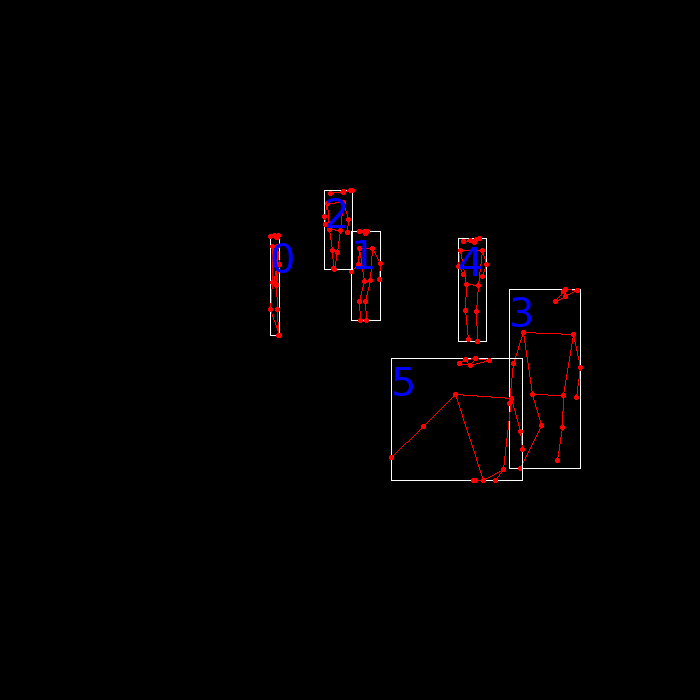

In [158]:
#_image_tool = ImageTool(size=(700,700))

_image_tool = PoseImageTool(size=(700,700))

for index,_pose in enumerate(_poses):
    _image_tool.drawBBox(_pose.bbox)
    
    _image_tool.addSkeleton(pose=_pose.pose)
    _image_tool.addPointsText(pose=_pose.pose,radius=2)
    
    x=_pose.bbox[0][0]
    y=_pose.bbox[0][1]
    fontsize=40
    _image_tool.drawText(str(index), x,y,fontsize, color='blue')     
    
_image_tool.image    

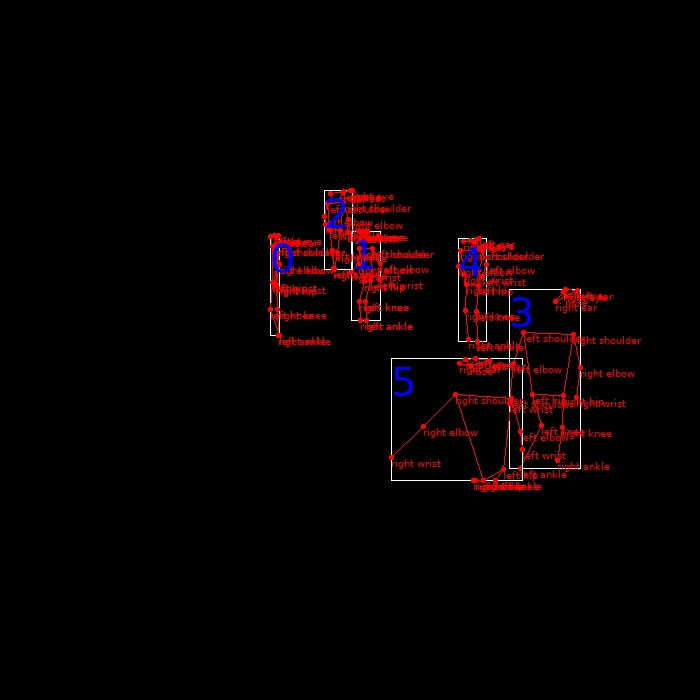

In [156]:
_image_tool.image

In [135]:
from PIL import Image
image = Image.new('RGB', (700,700))

for index,_pose in enumerate(_poses):
    drawBox(image,_pose.bbox)
    xys = get_xys(_pose.pose)
    addSkeleton(image,EDGES)
    addPointsText(image,xys.keys(),'red',2,1)
    
    x=_pose.bbox[0][0]
    y=_pose.bbox[0][1]
    fontsize=40
    drawText(image,str(index), x,y,fontsize, color='blue') 
    

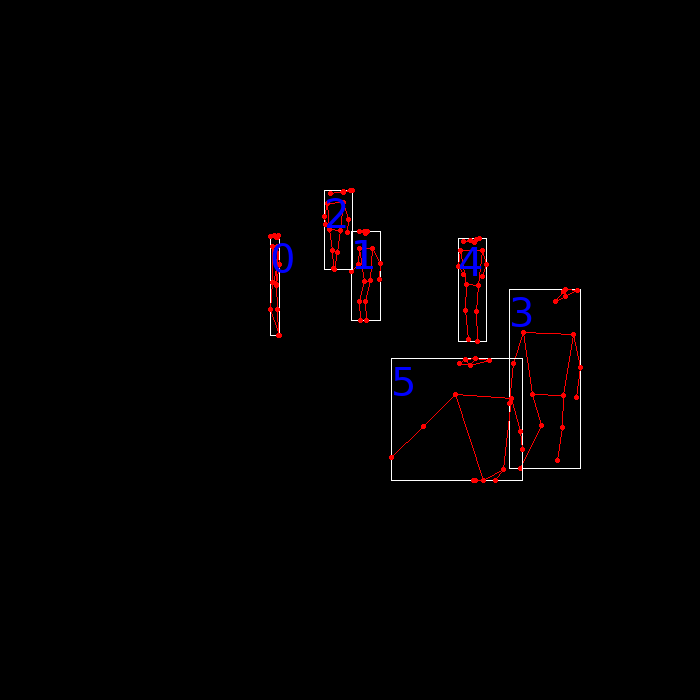

In [109]:
x=_poses[1].bbox[0][0]
y=_poses[1].bbox[0][1]
fontsize=40
drawText(image,str('1'), x,y,fontsize, color='blue')        
image
#_poses[1].pose

In [64]:
_poses[4].bbox

[[458, 238], [486, 341]]